In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
from keras import Sequential, Input
from keras.layers import Dense
import joblib


In [2]:
gold_path = Path.cwd().parent / 'data' / 'gold'
X_train = pd.read_parquet(gold_path / 'X_train.parquet',engine='pyarrow')
X_test = pd.read_parquet(gold_path / 'X_test.parquet',engine='pyarrow')
y_train = pd.read_parquet(gold_path / 'y_train.parquet',engine='pyarrow')
y_test = pd.read_parquet(gold_path / 'y_test.parquet',engine='pyarrow')

In [3]:
y_train = y_train.squeeze() # fixing bug

In [4]:
# Fix X and y dtypes
X_train = X_train.to_numpy(dtype="float32")
y_train = y_train.to_numpy(dtype="int32")  # for classification

# If using explicit validation data
# X_val = X_val.to_numpy(dtype="float32")
# y_val = y_val.to_numpy(dtype="int32")


In [5]:
class_weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.array([0, 1]),
    y=y_train
)


In [6]:


weights = {0: class_weights[0], 1: class_weights[1]}
print(weights)  

{0: np.float64(0.5008340614822464), 1: np.float64(300.23809523809524)}


In [7]:
# Criar o modelo
model = keras.Sequential([
    Input(shape=(X_train.shape[1],)),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(16, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid")
])

In [8]:
# Compilar o modelo
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=[
        "accuracy", 
        keras.metrics.Precision(), 
        keras.metrics.Recall(), 
        keras.metrics.AUC(),
        keras.metrics.AUC(curve='PR', name='pr_auc')
    ]
)


In [9]:
callback = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=2048,
    class_weight=weights,  # lidar com desbalanceamento
    callbacks=[callback],
    verbose=2
)

Epoch 1/50
89/89 - 4s - 42ms/step - accuracy: 0.9227 - auc: 0.7320 - loss: 0.6103 - pr_auc: 0.3700 - precision: 0.0128 - recall: 0.6033 - val_accuracy: 0.9608 - val_auc: 0.9079 - val_loss: 0.3795 - val_pr_auc: 0.7004 - val_precision: 0.0360 - val_recall: 0.8462
Epoch 2/50
89/89 - 0s - 3ms/step - accuracy: 0.9289 - auc: 0.9111 - loss: 0.3360 - pr_auc: 0.5490 - precision: 0.0181 - recall: 0.7900 - val_accuracy: 0.9856 - val_auc: 0.9429 - val_loss: 0.2767 - val_pr_auc: 0.7118 - val_precision: 0.0931 - val_recall: 0.8462
Epoch 3/50
89/89 - 0s - 3ms/step - accuracy: 0.9505 - auc: 0.9284 - loss: 0.3057 - pr_auc: 0.5662 - precision: 0.0269 - recall: 0.8233 - val_accuracy: 0.9851 - val_auc: 0.9632 - val_loss: 0.2120 - val_pr_auc: 0.7258 - val_precision: 0.0915 - val_recall: 0.8590
Epoch 4/50
89/89 - 0s - 3ms/step - accuracy: 0.9539 - auc: 0.9555 - loss: 0.2499 - pr_auc: 0.5595 - precision: 0.0302 - recall: 0.8633 - val_accuracy: 0.9794 - val_auc: 0.9716 - val_loss: 0.1753 - val_pr_auc: 0.7374 

In [11]:
print(history.history.keys())


dict_keys(['accuracy', 'auc', 'loss', 'pr_auc', 'precision', 'recall', 'val_accuracy', 'val_auc', 'val_loss', 'val_pr_auc', 'val_precision', 'val_recall'])


In [12]:
# Avaliar no conjunto de teste
y_pred_prob = model.predict(X_test).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_prob))

1774/1774 ━━━━━━━━━━━━━━━━━━━━ 1s 457us/step
[[55954   697]
 [   15    80]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56651
           1       0.10      0.84      0.18        95

    accuracy                           0.99     56746
   macro avg       0.55      0.91      0.59     56746
weighted avg       1.00      0.99      0.99     56746

ROC AUC Score: 0.9553311178601391


In [19]:
print(history.history.keys())

dict_keys(['accuracy', 'auc', 'loss', 'pr_auc', 'precision', 'recall', 'val_accuracy', 'val_auc', 'val_loss', 'val_pr_auc', 'val_precision', 'val_recall'])


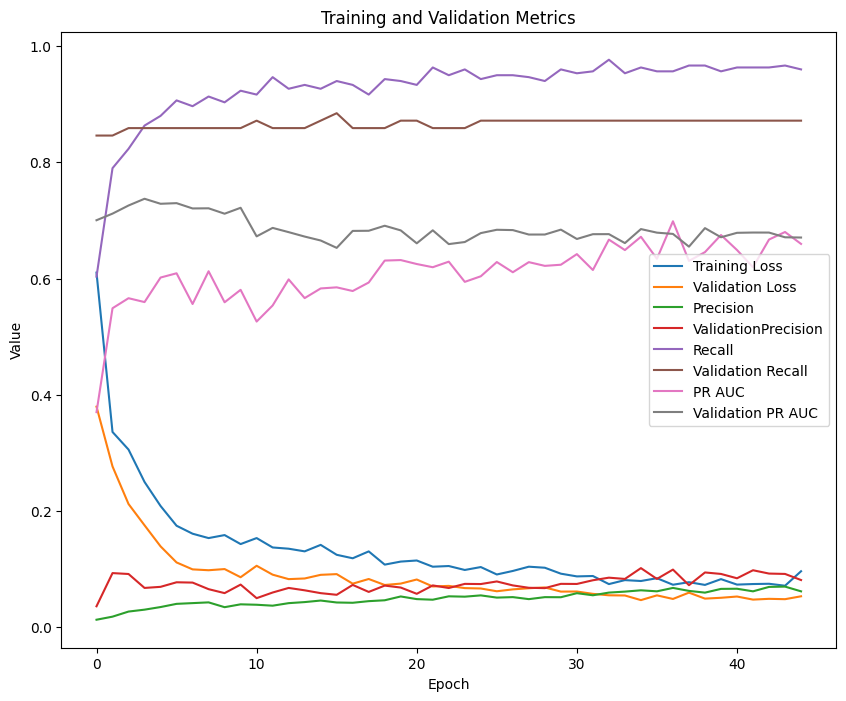

In [21]:
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.plot(history.history['precision'], label='Precision')
plt.plot(history.history['val_precision'], label='ValidationPrecision')

plt.plot(history.history['recall'], label='Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')

plt.plot(history.history['pr_auc'], label='PR AUC')
plt.plot(history.history['val_pr_auc'], label='Validation PR AUC')


plt.title('Training and Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()


In [24]:
# Save deep learning model using joblib in the 'models' directory
from pathlib import Path

model_dir = Path.cwd().parent / 'models'
model_dir.mkdir(exist_ok=True)

joblib.dump(model, model_dir / 'dl_model.joblib')

['e:\\Programacao\\LAPES\\EDA_ML_DL_PS\\LAPES-Data-Challenge-Predictive-Analytics-System\\models\\dl_model.joblib']